In [12]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
%matplotlib inline

import matplotlib as mpl
def save_plt(fig,name,folder):
    plt.savefig(os.path.join(folder, name+'.pdf'),
        format='pdf')

In [18]:
def get_pump_probe(window_start,window_length,folder_normalization):
    name = 'adwindata'
    b = pqsequence.TailAnalysis(folder_normalization, hdf5_mode='r', pq_device = '')
    b.get_sweep_pts()
    b.get_sweep_idxs(noof_syncs_per_sweep_pt=1)
    b.get_readout_results(name)
    b.get_tail_vs_sweep(0,window_start,window_length, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=False)
    return b,b.tail_cts_per_sweep_idx
def get_norm_pump_probe(window_start,window_length,folder_normalization):
    name = 'adwindata'
    b ,tail = get_pump_probe(window_start,window_length,folder_normalization)
    norm_y_err = np.sqrt(b.tail_cts_per_sweep_idx)/np.sqrt((b.reps*1/b.sweep_length))
    y_norm = np.average(b.tail_cts_per_sweep_idx)
    norm_y_err = np.sqrt(np.sum(norm_y_err**2))/len(norm_y_err)
    return y_norm,norm_y_err

def get_raw_singlet_data(t_list,base_f = None):
    cum_reps = 0
    syncs_per_sweep = 1

    for t in t_list:
        name = 'adwindata'
        folder_msmt=tb.latest_data(t)
        a = pqsequence.TailAnalysis(folder_msmt, hdf5_mode='r', pq_device = '')
        a.get_sweep_pts()
        a.get_sweep_idxs(noof_syncs_per_sweep_pt=1)
        a.get_readout_results(name)
        a.get_tail_vs_sweep(0,window_start,window_length, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=False)
        cum_reps += a.reps
        if t == t_list[0]:
            cum_tail_cts_per_sweep_idx = a.tail_cts_per_sweep_idx/len(t_list)
        else:
            cum_tail_cts_per_sweep_idx += a.tail_cts_per_sweep_idx/len(t_list)

    x = a.sweep_pts ### correction factor for distance
    y = cum_tail_cts_per_sweep_idx
    y_err = np.sqrt(cum_tail_cts_per_sweep_idx)/np.sqrt((cum_reps*syncs_per_sweep/a.sweep_length))

    a.plot_tail_hists_vs_sweep(save=False,log_plot = True)
    return a,x,y,y_err

In [14]:
#insert your time stamps here
pump_prob = ['170402','170640','170737','170837','170933','171029'] #results
normalization = '171416' # NV in |0> and no optical pi pulse
dark_cts  ='171232' # NV in |1> and no optical pi pulse
ssro_tstamp = '143110' # for potential PSB_SPCorr


window_start = 5230
window_length = 40
minimal_pulse_start = 5190

folder_normalization = tb.latest_data(normalization)
folder_dark = tb.latest_data(dark_cts)

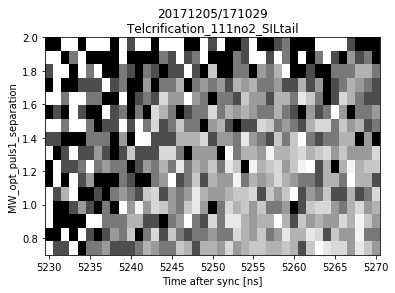

In [19]:
### get data
a,x,y,y_err = get_raw_singlet_data(pump_prob,base_f=base_f)

### rescale the x-axis:
# min distance between pump and probe has to be calculated from starting points in the counthistogram
#here all input values were taken for a window start of 5230 ns
x = x*(-1)
x = x-np.amin(x)+(5230-minimal_pulse_start)*1e-3 + (window_start-5230)*1e-3

### normalize to the reference msmt (we only detect counts from ms=0)
y_norm,norm_y_err = get_norm_pump_probe(window_start,window_length,folder_normalization)

### incorporate dark counts
b,y_dark = get_pump_probe(window_start,window_length,folder_dark)
y_err = np.sqrt((y_norm*y_err)**2+(y*norm_y_err)**2)/y_norm**2
y = (y-y_dark)/y_norm
y_lt4 = y;x_lt4 = x;y_err_lt4=y_err

Converged with chi squared  0.000447287636415
degrees of freedom, dof  13
RMS of residuals (i.e. sqrt(chisq/dof))  0.00586572597917
Reduced chisq (i.e. variance of residuals)  3.44067412627e-05

fitted parameters at minimum, with 68% C.I.:
 0 a              0.276650 +/-   0.004530
 1 A             -0.263586 +/-   0.005716
 2 tau            0.402728 +/-   0.025169

correlation matrix:
               a         A         tau       
         a  1.000000
         A -0.279005  1.000000
       tau  0.876722  0.086016  1.000000

plot saved in  M:\tnw\ns\qt\Diamond\Eigenpapers\17_QMemories2\Data\SingletPumpProbeLT4\20171205\171029_Telcrification_111no2_SILtail


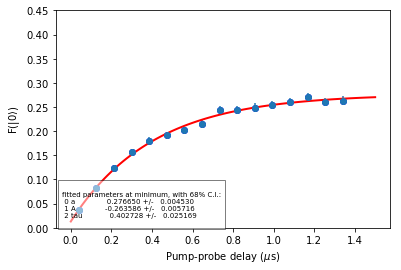

In [23]:
#plotting
fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(x_lt4,y_lt4,y_err_lt4, fmt = 'o')
p0,fitfunc,fitfunc_str = common.fit_exp_decay_shifted_with_offset(np.amax(y),-np.amax(y)/3.,0.4,0)
fit_result4 = fit.fit1d(x_lt4,y_lt4,None,p0=p0,fitfunc=fitfunc,do_print=True,fixed=[3],ret=True)
plot.plot_fit1d(fit_result4,fit_xvals=np.linspace(0,1.5,100),ax=ax)
ax.set_xlabel(r'Pump-probe delay ($\mu$s)')
ax.set_ylabel(r'$\mathrm{F(|0\rangle)}$')
plt.legend(frameon=False,loc=1,bbox_to_anchor=(0.95, 1))
plt.ylim([0,0.45])
print 'plot saved in ', a.folder
save_plt(fig,'singlet_pump_prob',folder = a.folder)
plt.show()
